## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk
import random
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
print(nltk_data[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [4]:
random.seed(1234)
train_set, test_set = train_test_split(nltk_data, test_size=0.05)

In [5]:
print(len(train_set))
print(len(test_set))

3718
196


In [6]:
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95655

In [7]:
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Bank', 'of', 'New', 'England', 'Corp.', 'said', '0', 'it', 'has', 'held']

In [8]:
V = set(tokens)
print(len(V))

12085


In [9]:
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [10]:
print(T)

{'.', 'X', 'NUM', 'ADP', 'NOUN', 'PRON', 'ADV', 'ADJ', 'PRT', 'DET', 'VERB', 'CONJ'}


### Build the vanilla Viterbi based POS tagger

#### Emission probabilities: 

In [11]:
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [12]:
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    return (count_w_given_tag, count_tag)

In [13]:
print(word_given_tag('Think', 'VERB'))
print(word_given_tag('Think', '.'))
print(word_given_tag('Think', 'PRT'))


(2, 12866)
(0, 11122)
(0, 3046)


In [14]:
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [15]:
print(t2_given_t1(t2='PRON', t1='VERB'))

(457, 12866)


In [16]:
tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [17]:
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df.head()

,.,X,NUM,ADP,NOUN,PRON,ADV,ADJ,PRT,DET,VERB,CONJ
.,0.091171,0.027153,0.081280,0.091530,0.222262,0.066445,0.052778,0.044416,0.002428,0.173620,0.088653,0.058173
X,0.165235,0.075223,0.002863,0.144243,0.062182,0.056298,0.025445,0.017017,0.183047,0.055184,0.202767,0.010496
NUM,0.118741,0.213493,0.183208,0.035382,0.351124,0.001499,0.002999,0.033283,0.026687,0.002999,0.017091,0.013493
ADP,0.039932,0.034821,0.062187,0.017251,0.322756,0.067511,0.013843,0.107124,0.001491,0.324353,0.007986,0.000745
NOUN,0.239731,0.028888,0.009387,0.176933,0.264835,0.004730,0.016882,0.012188,0.043733,0.012625,0.147426,0.042641


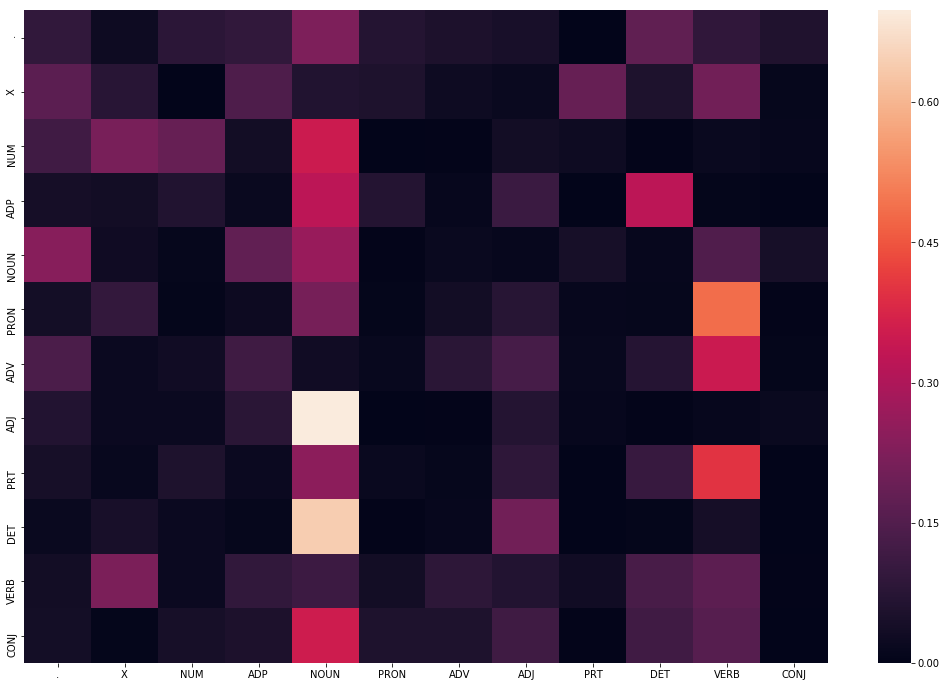

In [18]:
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

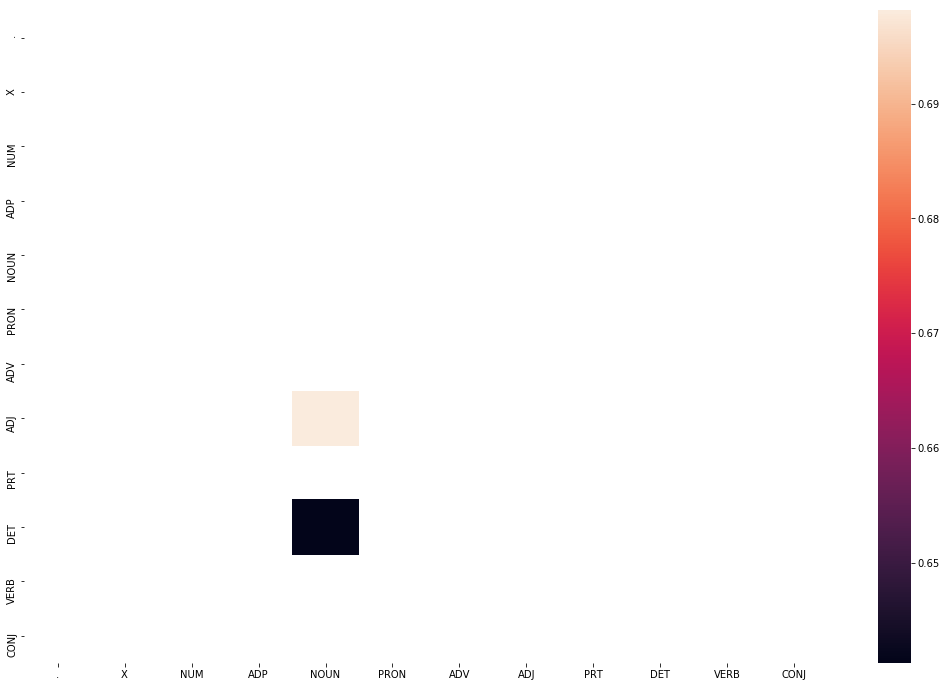

In [19]:
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

In [20]:
tags_df

,.,X,NUM,ADP,NOUN,PRON,ADV,ADJ,PRT,DET,VERB,CONJ
.,0.091171,0.027153,0.081280,0.091530,0.222262,0.066445,0.052778,0.044416,0.002428,0.173620,0.088653,0.058173
X,0.165235,0.075223,0.002863,0.144243,0.062182,0.056298,0.025445,0.017017,0.183047,0.055184,0.202767,0.010496
NUM,0.118741,0.213493,0.183208,0.035382,0.351124,0.001499,0.002999,0.033283,0.026687,0.002999,0.017091,0.013493
ADP,0.039932,0.034821,0.062187,0.017251,0.322756,0.067511,0.013843,0.107124,0.001491,0.324353,0.007986,0.000745
NOUN,0.239731,0.028888,0.009387,0.176933,0.264835,0.004730,0.016882,0.012188,0.043733,0.012625,0.147426,0.042641
PRON,0.037779,0.093292,0.006939,0.023130,0.212413,0.007710,0.034310,0.072860,0.012336,0.009252,0.484580,0.005397
ADV,0.137542,0.021595,0.031561,0.117276,0.032558,0.014950,0.077076,0.129568,0.014618,0.069103,0.347176,0.006977
ADJ,0.064914,0.021035,0.020707,0.078554,0.698110,0.000493,0.004273,0.066393,0.011175,0.005094,0.011668,0.017584
PRT,0.042679,0.014117,0.054826,0.020026,0.247866,0.018056,0.009849,0.086999,0.001970,0.101116,0.400197,0.002298
DET,0.017518,0.044219,0.021989,0.008699,0.641295,0.003625,0.012444,0.204664,0.000242,0.005799,0.039024,0.000483


In [21]:
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [22]:
random.seed(345)
rndom = [random.randint(1,len(test_set)) for x in range(5)]
test_run = [test_set[i] for i in rndom]
test_run_base = [tup for sent in test_run for tup in sent]
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('The', 'DET'),
  ('bonus', 'NOUN'),
  ('depended', 'VERB'),
  ('on', 'ADP'),
  ('her', 'PRON'),
  ('ability', 'NOUN'),
  ('*', 'X'),
  ('to', 'PRT'),
  ('produce', 'VERB'),
  ('higher', 'ADJ'),
  ('student-test', 'ADJ'),
  ('scores', 'NOUN'),
  ('.', '.')],
 [('Still', 'ADV'),
  ('unresolved', 'ADJ'),
  ('is', 'VERB'),
  ('*T*-1', 'X'),
  ('Sony', 'NOUN'),
  ("'s", 'PRT'),
  ('effort', 'NOUN'),
  ('*', 'X'),
  ('to', 'PRT'),
  ('hire', 'VERB'),
  ('producers', 'NOUN'),
  ('Jon', 'NOUN'),
  ('Peters', 'NOUN'),
  ('and', 'CONJ'),
  ('Peter', 'NOUN'),
  ('Guber', 'NOUN'),
  ('to', 'PRT'),
  ('run', 'VERB'),
  ('the', 'DET'),
  ('studio', 'NOUN'),
  ('.', '.')],
 [('Of', 'ADP'),
  ('the', 'DET'),
  ('approximately', 'ADV'),
  ('200', 'NUM'),
  ('sponsors', 'NOUN'),
  ('of', 'ADP'),
  ('the', 'DET'),
  ('recent', 'ADJ'),
  ('march', 'NOUN'),
  ('in', 'ADP'),
  ('Washington', 'NOUN'),
  ('for', 'ADP'),
  ('the', 'DET'),
  ('homeless', 'NOUN'),
  (',', '.'),
  ('you', 'PRON'),
  ('chose', 

In [23]:
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start
difference

42.57274508476257

In [24]:
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
accuracy

0.8529411764705882

In [25]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('bonus', 'NOUN'), (('depended', '.'), ('depended', 'VERB'))],
 [('higher', 'ADJ'), (('student-test', '.'), ('student-test', 'ADJ'))],
 [('Still', 'ADV'), (('unresolved', '.'), ('unresolved', 'ADJ'))],
 [('producers', 'NOUN'), (('Jon', '.'), ('Jon', 'NOUN'))],
 [('Jon', 'NOUN'), (('Peters', '.'), ('Peters', 'NOUN'))],
 [('Peter', 'NOUN'), (('Guber', '.'), ('Guber', 'NOUN'))],
 [('200', 'NUM'), (('sponsors', '.'), ('sponsors', 'NOUN'))],
 [('the', 'DET'), (('homeless', 'ADJ'), ('homeless', 'NOUN'))],
 [('you', 'PRON'), (('chose', '.'), ('chose', 'VERB'))],
 [('Home', 'NOUN'), (('Builders', '.'), ('Builders', 'NOUN'))],
 [('of', 'ADP'), (('Bricklayers', '.'), ('Bricklayers', 'NOUN'))],
 [('Allied', 'NOUN'), (('Craftsmen', '.'), ('Craftsmen', 'NOUN'))],
 [('*-1', 'X'), (('insinuating', '.'), ('insinuating', 'VERB'))],
 [('insinuating', 'VERB'), (('that', 'DET'), ('that', 'ADP'))],
 [('from', 'ADP'), (('self-serving', '.'), ('self-serving', 'ADJ'))],
 [('groups', 'NOUN'), (('that', 'ADP'

In [26]:
wrong_tagged_words = [j[0][0] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]
wrong_tagged_words

['depended',
 'student-test',
 'unresolved',
 'Jon',
 'Peters',
 'Guber',
 'sponsors',
 'homeless',
 'chose',
 'Builders',
 'Bricklayers',
 'Craftsmen',
 'insinuating',
 'that',
 'self-serving',
 'that',
 'that',
 'crusade',
 'sky',
 'high',
 'bombarding',
 'neutrons',
 'that',
 'radioactivity',
 'large-scale']

### Solve the problem of unknown words

In [27]:
print(T)

{'.', 'X', 'NUM', 'ADP', 'NOUN', 'PRON', 'ADV', 'ADJ', 'PRT', 'DET', 'VERB', 'CONJ'}


In [28]:
pattern = [
    (r'.*ing$', 'VERB'),
    (r'.*ed$', 'VERB'),
    (r'.*es$', 'VERB'),
    (r'.*ould$', 'ADJ'),
    (r'.*\'s$', 'NOUN'),
    (r'.*s$', 'NOUN'),
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'),
    (r'.*', 'NOUN')
]

class PosTagger:
    
    def __init__(self, train_set):
        self.train_set = train_set
    
    def get_pos_tagger(self):
        reg_tagger = nltk.RegexpTagger(pattern, backoff=nltk.DefaultTagger('ADJ'))
        affix_tagger = nltk.AffixTagger(train_set, backoff=reg_tagger)
        unigram_tagger = nltk.UnigramTagger(train_set, backoff=reg_tagger)
        bigram_tagger = nltk.BigramTagger(train_set, backoff=unigram_tagger)
        return bigram_tagger

In [29]:
pos_tagger = PosTagger(train_set)
tagger = pos_tagger.get_pos_tagger()
tagger.tag([test_tagged_words[0]])

[('The', 'DET')]

In [30]:
def ViterbiWithPosTagger(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        if(pmax == 0):
            state_max = tagger.tag([word])[0][1]
        else:
            state_max = T[p.index(pmax)]
         
        state.append(state_max)
    return list(zip(words, state))

In [31]:
tagged_seq = ViterbiWithPosTagger(test_tagged_words)

#### Evaluating tagging accuracy

In [32]:
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
modified_accuracy = len(check)/len(tagged_seq)
modified_accuracy

0.9294117647058824

In [33]:
reg_incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
reg_incorrect_tagged_cases

[[('higher', 'ADJ'), (('student-test', 'NOUN'), ('student-test', 'ADJ'))],
 [('Still', 'ADV'), (('unresolved', 'VERB'), ('unresolved', 'ADJ'))],
 [('the', 'DET'), (('homeless', 'ADJ'), ('homeless', 'NOUN'))],
 [('you', 'PRON'), (('chose', 'NOUN'), ('chose', 'VERB'))],
 [('from', 'ADP'), (('self-serving', 'VERB'), ('self-serving', 'ADJ'))],
 [('groups', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('and', 'CONJ'), (('that', 'DET'), ('that', 'ADP'))],
 [('sky', 'NOUN'), (('high', 'ADJ'), ('high', 'ADV'))],
 [('process', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('for', 'ADP'), (('large-scale', 'NOUN'), ('large-scale', 'ADJ'))],
 [('large-scale', 'ADJ'), (('commercial', 'NOUN'), ('commercial', 'ADJ'))],
 [('commercial', 'ADJ'), (('use', 'VERB'), ('use', 'NOUN'))]]

In [34]:
wrong_tagged_words_with_regexp = [j[0][0] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]
wrong_tagged_words_with_regexp

['student-test',
 'unresolved',
 'homeless',
 'chose',
 'self-serving',
 'that',
 'that',
 'high',
 'that',
 'large-scale',
 'commercial',
 'use']

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

#### Accuracy with viterbi and Regexp tagging

In [35]:
modified_accuracy

0.9294117647058824

#### Accuracy with viterbi tagging

In [36]:
accuracy

0.8529411764705882

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

##### Wrong tagged words with POS tagging included:

In [37]:
set(wrong_tagged_words_with_regexp)

{'chose',
 'commercial',
 'high',
 'homeless',
 'large-scale',
 'self-serving',
 'student-test',
 'that',
 'unresolved',
 'use'}

##### Wrong tagged words with vetarbi tagging without POS tagging: 

In [38]:
set(wrong_tagged_words)

{'Bricklayers',
 'Builders',
 'Craftsmen',
 'Guber',
 'Jon',
 'Peters',
 'bombarding',
 'chose',
 'crusade',
 'depended',
 'high',
 'homeless',
 'insinuating',
 'large-scale',
 'neutrons',
 'radioactivity',
 'self-serving',
 'sky',
 'sponsors',
 'student-test',
 'that',
 'unresolved'}

##### POS taggers corrected by regexp tagging after vitarbi  tagging

In [39]:
set(wrong_tagged_words).difference(set(wrong_tagged_words_with_regexp))

{'Bricklayers',
 'Builders',
 'Craftsmen',
 'Guber',
 'Jon',
 'Peters',
 'bombarding',
 'crusade',
 'depended',
 'insinuating',
 'neutrons',
 'radioactivity',
 'sky',
 'sponsors'}

In [40]:
[word for word in tagged_seq if word[0] =='disparate']

[]

In [41]:
reg_incorrect_tagged_cases

[[('higher', 'ADJ'), (('student-test', 'NOUN'), ('student-test', 'ADJ'))],
 [('Still', 'ADV'), (('unresolved', 'VERB'), ('unresolved', 'ADJ'))],
 [('the', 'DET'), (('homeless', 'ADJ'), ('homeless', 'NOUN'))],
 [('you', 'PRON'), (('chose', 'NOUN'), ('chose', 'VERB'))],
 [('from', 'ADP'), (('self-serving', 'VERB'), ('self-serving', 'ADJ'))],
 [('groups', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('and', 'CONJ'), (('that', 'DET'), ('that', 'ADP'))],
 [('sky', 'NOUN'), (('high', 'ADJ'), ('high', 'ADV'))],
 [('process', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('for', 'ADP'), (('large-scale', 'NOUN'), ('large-scale', 'ADJ'))],
 [('large-scale', 'ADJ'), (('commercial', 'NOUN'), ('commercial', 'ADJ'))],
 [('commercial', 'ADJ'), (('use', 'VERB'), ('use', 'NOUN'))]]

### Testing the sentences:

In [42]:
test_data = pd.read_csv('https://cdn.upgrad.com/UpGrad/temp/9dca5f3b-53c3-47e1-86d5-5ec5dafad6f0/Test_sentences.txt', header=None, delimiter='\n')

In [43]:
for sent in test_data[0]:
    words = nltk.word_tokenize(sent)
    print('sentence: \n', sent)
    print('Viterbi algorithm without Regexp POS tagging: \n')
    print(Viterbi(words), '\n')
    print('Viterbi algorithm with Regexp POS tagging: \n')
    print(ViterbiWithPosTagger(words), '\n')

sentence: 
 Android is a mobile operating system developed by Google.
Viterbi algorithm without Regexp POS tagging: 

[('Android', '.'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', '.'), ('.', '.')] 

Viterbi algorithm with Regexp POS tagging: 

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')] 

sentence: 
 Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.
Viterbi algorithm without Regexp POS tagging: 

[('Android', '.'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', '.'), ('worldwide', '.'), ('on', 'ADP'), ('smartphones', '.'), ('since', 'ADP'), ('2011', '.'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', '.'), ('.', '.')] 

Viterbi algor

[('NASA', 'NOUN'), ('invited', 'VERB'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'NOUN'), ('Satellite', 'NOUN'), ('.', '.')] 



In [45]:
from itertools import chain
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer

# pip/conda install sklearn_crfsuite
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from sklearn_crfsuite import scorers


def word_features(sent, i):
    word = sent[i][0]
    pos = sent[i][1]
    
    # first word
    if i==0:
        prevword = '<START>'
        prevpos = '<START>'
    else:
        prevword = sent[i-1][0]
        prevpos = sent[i-1][1]
    
    # last word
    if i == len(sent)-1:
        nextword = '<END>'
        nextpos = '<END>'
    else:
        nextword = sent[i+1][0]
        nextpos = sent[i+1][1]
    
    # word is in gazetteer    
    # suffixes and prefixes
    pref_1, pref_2, pref_3, pref_4 = word[:1], word[:2], word[:3], word[:4]
    suff_1, suff_2, suff_3, suff_4 = word[-1:], word[-2:], word[-3:], word[-4:]
    
    return {'word':word,
            'pos': pos, 
            'prevword': prevword,
            'prevpos': prevpos,  
            'nextword': nextword, 
            'nextpos': nextpos,
            'word_is_digit': word in 'DIGITDIGITDIGIT',
            'suff_1': suff_1,  
            'suff_2': suff_2,  
            'suff_3': suff_3,  
            'suff_4': suff_4, 
            'pref_1': pref_1,  
            'pref_2': pref_2,  
            'pref_3': pref_3, 
            'pref_4': pref_4 }  

word_features(train_tagged_words[0], i=3)

IndexError: tuple index out of range

In [46]:
train_tagged_words[0]

('Bank', 'NOUN')